In [61]:
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import multivariate_normal

Make fake data:

In [225]:
# np.random.seed(123)
np.random.seed(456)

N = 5  # number of data points
t = np.sort(np.random.uniform(0, 1, size=N))
sig_y = np.random.uniform(0.1, 0.5, size=N)  # noise! MAGIC NUMBER
C = np.diag(sig_y**2)
y = 10 + np.random.normal(0., sig_y, size=N)

nsamples = 16384  # number of samples of the nonlinear parameter
P_lim = [1e-2, 1e4]
P_samples = np.exp(np.random.uniform(np.log(P_lim[0]), 
                                     np.log(P_lim[1]),
                                     size=nsamples))

# hyperprior on linear parameters:
mu_th = np.array([0., 0, 0])
V = np.diag([1e2, 1e2, 1e2]) ** 2
# mu_th = np.array([0., 0])
# V = np.diag([1e3, 1e3]) ** 2

In [226]:
M = np.stack((np.ones((N, nsamples)),
              np.cos(2*np.pi*t[:, None] / P_samples[None]),
              np.sin(2*np.pi*t[:, None] / P_samples[None]))).T
# M = np.stack((np.ones((N, nsamples)),
#               np.cos(2*np.pi*t[:, None] / P_samples[None]))).T

In [227]:
def get_aA_bB(M, y, C, mu, V):
    Cinv = np.linalg.inv(C)
    Vinv = np.linalg.inv(V)
    
    A = C + M.dot(V).dot(M.T)
    Ainv = np.linalg.inv(A)
    Binv = Vinv + M.T.dot(Cinv).dot(M)
    B = np.linalg.inv(Binv)

    a = M.dot(mu)
    b = B.dot(M.T.dot(Cinv).dot(y) + Vinv.dot(mu))

    return a, A, b, B

In [228]:
lls = np.zeros(nsamples)
samples = np.zeros((nsamples, M.shape[-1]))
for i in range(nsamples):
    a, A, b, B = get_aA_bB(M[i], y, C, mu_th, V)
    lls[i] = multivariate_normal.logpdf(y, mean=a, cov=A)
    samples[i] = np.random.multivariate_normal(b, B)

In [229]:
uu = np.random.uniform(size=nsamples)
good_samples_mask = uu < np.exp(lls - lls.max())

In [230]:
good_samples_mask.sum()

3598

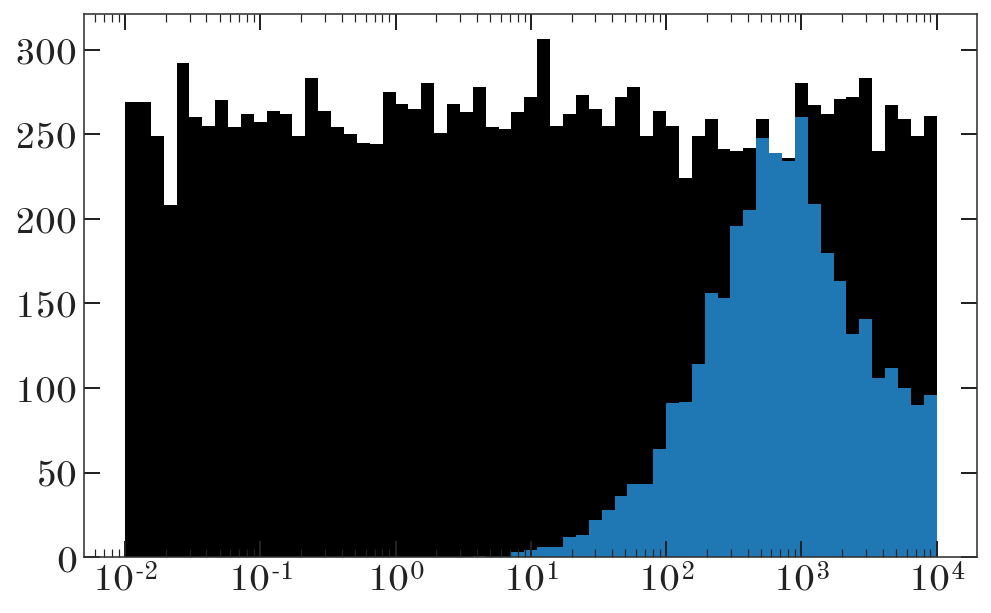

In [231]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
_, bins, *_ = ax.hist(P_samples, bins=np.geomspace(P_lim[0], P_lim[1], 64))
ax.hist(P_samples[good_samples_mask], bins=bins)
ax.set_xscale('log')

(array([  9.,  42., 172., 460., 820., 969., 699., 325.,  92.,  10.]),
 array([-254.78804652, -205.80281405, -156.81758158, -107.83234911,
         -58.84711664,   -9.86188417,   39.1233483 ,   88.10858077,
         137.09381324,  186.07904571,  235.06427818]),
 <a list of 10 Patch objects>)

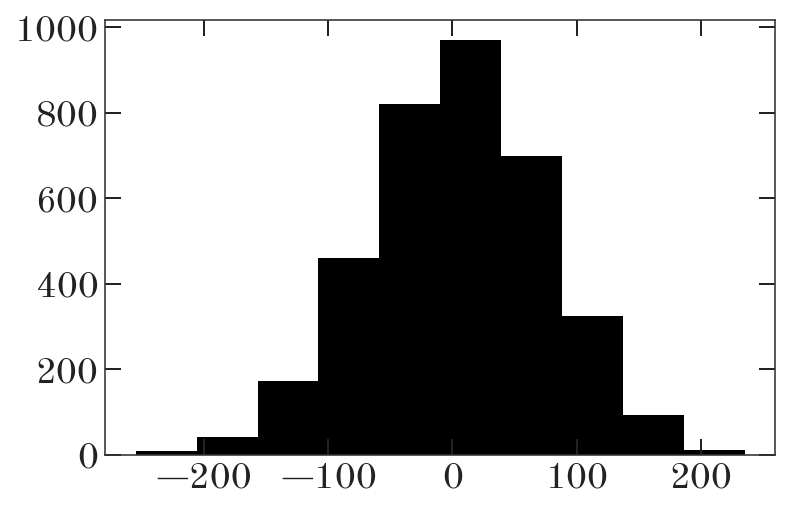

In [241]:
plt.hist(samples[good_samples_mask, 0])

(7.667597938878545, 11.667597938878545)

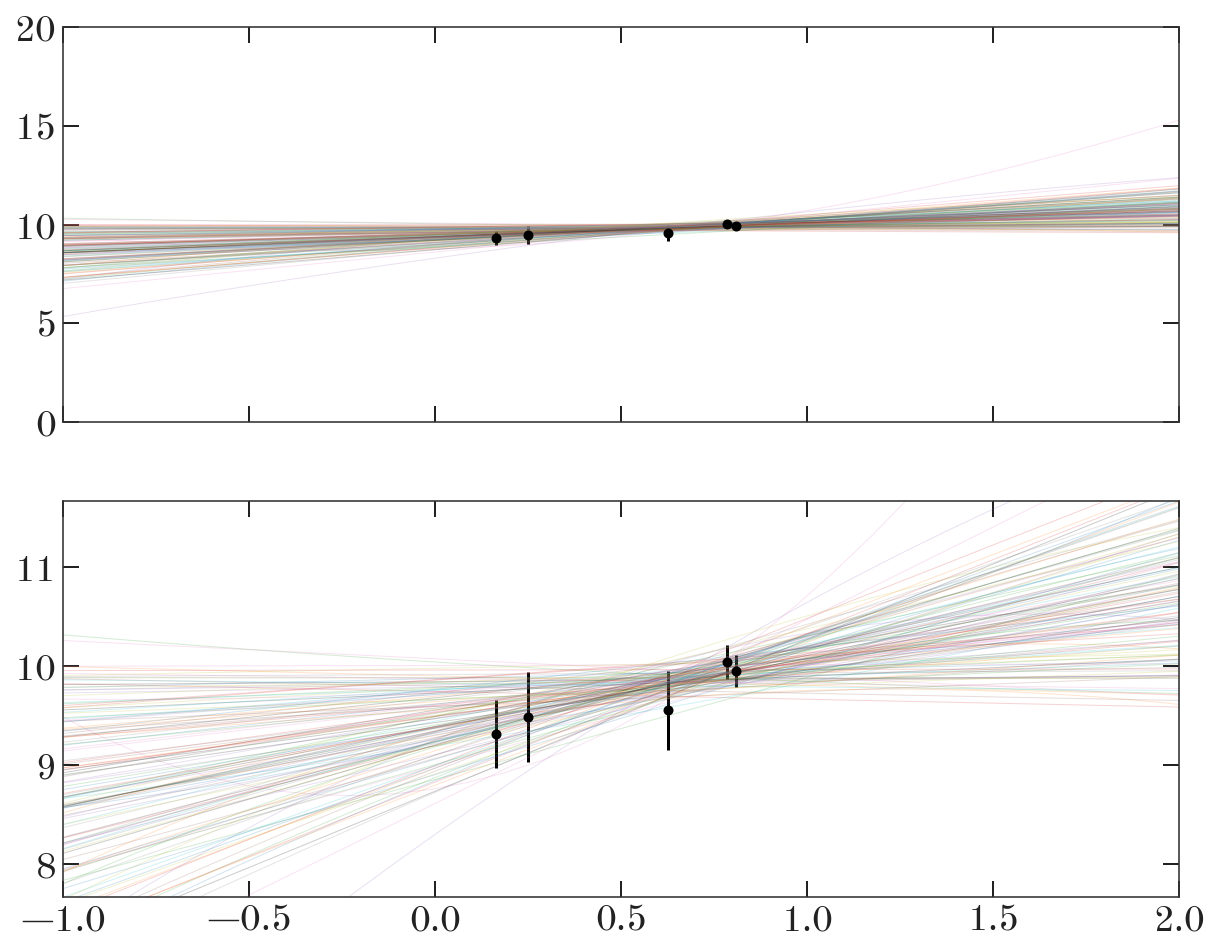

In [232]:
model_t = np.linspace(-1, 100., 1024)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

for ax in axes:
    ax.errorbar(t, y, sig_y, marker='o', ls='none')

    for j in np.where(good_samples_mask)[0][:128]:
        ax.plot(model_t, 
                (samples[j][0] + samples[j][1] * np.cos(2*np.pi*model_t / P_samples[j]) + 
                 samples[j][2] * np.sin(2*np.pi*model_t / P_samples[j])),
                marker='', lw=0.5, alpha=0.2)

axes[0].set_ylim(0, 20)
axes[1].set_xlim(-1, 2)
axes[1].set_ylim(np.mean(y) - 2, np.mean(y) + 2)